<a href="https://colab.research.google.com/github/JuniorHZ19/CNN-PARA-DETECION-DE-OBJETOS/blob/main/FAST%20R-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:

!pip uninstall opencv-contrib-python opencv-python
!pip install opencv-contrib-python
!pip install torchmetrics

Found existing installation: opencv-contrib-python 4.11.0.86
Uninstalling opencv-contrib-python-4.11.0.86:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/cv2/*
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python-4.11.0.86.dist-info/*
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5Core-e7f476e2.so.5.15.16
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5Gui-1ce8cbfe.so.5.15.16
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5Test-9ac3ed15.so.5.15.16
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5Widgets-cd430389.so.5.15.16
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libQt5XcbQpa-b18b5a78.so.5.15.16
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libX11-xcb-0e257303.so.1.0.0
    /usr/local/lib/python3.11/dist-packages/opencv_contrib_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.11

(2000, 4)


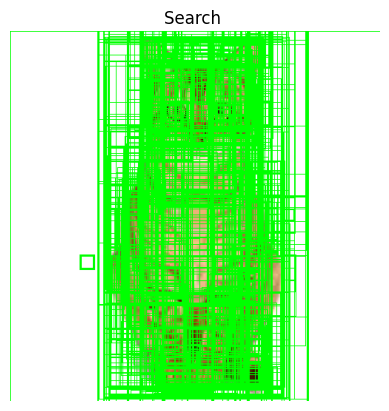

In [2]:
import cv2
import matplotlib.pyplot as plt
def generate_rois(img,max_regiones=2000,fast_mode=False):

      # Crear un objeto de Selective Search

        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

        image_bgr = cv2.cvtColor(img , cv2.COLOR_RGB2BGR)

      # Configurar la imagen para Selective Search
        ss.setBaseImage(image_bgr)

      # Modo rápido o calidad

        if (fast_mode==True):

          ss.switchToSelectiveSearchFast()

        else :
          ss.switchToSelectiveSearchQuality()  # Más preciso pero más lentoiso

      # Ejecutar Selective Search para obtener las regiones propuestas
        rects = ss.process()

        rects= rects[:max_regiones]

        rois = []

        for x, y, w, h in rects:
           rois.append([x, y, x + w, y + h]) #formato xmin,ymin ,xmax,ymax


        return torch.tensor(rois, dtype=torch.float32)



image = cv2.imread('/content/imagenes/69.jpg')

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

scale_rate=1 #sacale rate q se aplciara a la resolucion de la imagen (proporcion que se reducirar) y a las coordenadas de los rois

h, w = image.shape[:2]

image_rgb = cv2.resize(image_rgb, (int(w * scale_rate), int(h * scale_rate)), interpolation=cv2.INTER_AREA)

rectas_propuestas=generate_rois(image)*scale_rate #generamos los rois que la funcion devuelve en formato tensor

rectas_propuestas_np=rectas_propuestas.numpy() #pasamos los rois a formato numpy para poder dibujarlo en matplotlib
print(rectas_propuestas_np.shape)

# Dibujar las regiones propuestas en la imagen
for (x, y, xmax, ymax) in rectas_propuestas_np:  # Limitar a las primeras 100 regiones para visualizar
    cv2.rectangle(image_rgb, (int(x), int(y)), (int(xmax), int(ymax)), (0, 255, 0), 1)

# Mostrar la imagen con Matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Ocultar los ejes
plt.title("Search ")
plt.show()

In [3]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import cv2 as cv2
class PascalVOCDataset(Dataset):

    def __init__(self, images_dir, annotations_dir,ref_labels, transform=None):
        self.ref_labels=ref_labels #referencia posiciones de cada clase seguira el mismo orden +1
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir

        if(transform is not None):
           self.transform = transform
        else:
          self.transform=transforms.ToTensor()

        # Lista de todas las imágenes y sus anotaciones
        self.image_filenames = [
            f for f in os.listdir(images_dir) if f.endswith((".jpg", ".png"))
        ]

    def __len__(self):
        """Devuelve el tamaño del dataset."""
        return len(self.image_filenames)

    def __getitem__(self, idx):

        # Cargar la imagen
        image_filename = self.image_filenames[idx]

        image_path = os.path.join(self.images_dir, image_filename)

        image=cv2.imread(image_path)


        # Cargar la anotación correspondiente
        annotation_path = os.path.join(
            self.annotations_dir, os.path.splitext(image_filename)[0] + ".xml"
        )

        target = self._parse_annotation(annotation_path)

        rois=generate_rois(image)

        image_tensor=self.transform(image)

        return image_tensor, rois , target['boxes'],target['labels']


    def _parse_annotation(self, annotation_path):

        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"):
            label = obj.find("name").text
            label= (self.ref_labels.index(label))+1
            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            }

        return target





In [4]:
import torchvision.models as models
from torchvision.ops.roi_pool import RoIPool
import torch.nn as nn
class Fast_RCNN(nn.Module):

 def __init__(self,num_clases):

    super(Fast_RCNN, self).__init__()

    self.backbone = models.vgg16(weights=models.VGG16_Weights.DEFAULT).to(device) #solo tomamos las capas combolcionales de la red omitinedo el clasificador de la ultima capa
    self.backbone = nn.Sequential(*list(self.backbone.children())[:-2])  # Exclude final layer que en vgg16 es un avg polling

    # RoI Pooling
    self.roi_pooling = RoIPool((7, 7), spatial_scale=1/16)

    self.flatten = nn.Flatten(start_dim=1)

    # Fully Connected Layers for Classification

    self.fc_cls = nn.Linear(512 * 7 * 7, num_clases)  # 512 es el número de canales de VGG16, 7x7 es el tamaño de RoI Pool

    self.fc_bbox = nn.Linear(512 * 7 * 7, 4)  # Para coordenadas de caja delimitadora (x, y, w, h)

 def forward(self, x,rois):

        # Backbone feature extraction
        x = self.backbone(x)

        x = self.roi_pooling(x,rois)

        # Flatten pooled features
        x = self.flatten(x)

        # Classification
        cls_scores = self.fc_cls(x)

        # Bounding box regression
        bbox_offsets = self.fc_bbox(x)

        return cls_scores, bbox_offsets

In [5]:
from torchvision import transforms
import numpy as np
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader
# Directorios del dataset
images_dir = "/content/imagenes"
annotations_dir = "/content/anotaciones"

# Definir transformaciones
transform = transforms.Compose([
    transforms.ToTensor(),  # Convierte a tensor

])


# Crear el dataset
dataset = PascalVOCDataset(images_dir, annotations_dir,ref_labels=['gato','perro'],transform=transform)

# Particionar dataset en train y test
train_size = int(0.8 * len(dataset))  # 80% para entrenamiento
test_size = len(dataset) - train_size  # El resto para prueba

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

image, rois , bboxs,labels=train_dataset[0]



train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True)

first_images, first_rois,first_bboxs,first_labels = next(iter(train_loader))

# Verificar el tamaño de las imágenes
print("Tamaño de las imágenes:", first_images.shape)

# Verificar anotaciones
print("Rois:", first_bboxs.shape)
print("labels:", first_labels.shape)

Tamaño de las imágenes: torch.Size([10, 3, 500, 500])
Rois: torch.Size([10, 1, 4])
labels: torch.Size([10, 1])


In [6]:
#funciones para calcular las ranfomaciones (que tanto se desplza el boudnig box propuesto del real t_x, t_y, t_w, t_h) cual entrara al regresor que calcuialra estos translacion


def calculate_translation(bbox_pred, bbox_real):
    """
    Calcula los deltas para ajustar un bbox predicho a su equivalente real.

    Args:
        bbox_pred: (xmin_pred, ymin_pred, xmax_pred, ymax_pred)
        bbox_real: (xmin_real, ymin_real, xmax_real, ymax_real)

    Returns:
        deltas: (dx, dy, dw, dh) -> Desplazamiento en x, y, ancho y alto.
    """
    # Extracción de coordenadas
    x_center_pred = (bbox_pred[:, 0] + bbox_pred[:, 2]) / 2
    y_center_pred = (bbox_pred[:, 1] + bbox_pred[:, 3]) / 2
    w_pred = bbox_pred[:, 2] - bbox_pred[:, 0]
    h_pred = bbox_pred[:, 3] - bbox_pred[:, 1]

    x_center_real = (bbox_real[:, 0] + bbox_real[:, 2]) / 2
    y_center_real = (bbox_real[:, 1] + bbox_real[:, 3]) / 2
    w_real = bbox_real[:, 2] - bbox_real[:, 0]
    h_real = bbox_real[:, 3] - bbox_real[:, 1]

    # Calcular deltas
    dx = x_center_real - x_center_pred
    dy = y_center_real - y_center_pred
    dw = torch.log(w_real / w_pred)
    dh = torch.log(h_real / h_pred)

    deltas = torch.stack([dx, dy, dw, dh], dim=-1)
    return deltas


import numpy as np

def reverse_translation(bbox_pred, deltas):
    """
    Calcula las coordenadas del bbox real a partir de un bbox predicho y los deltas.

    Args:
        bbox_pred: Tensor de forma (N, 4) con las coordenadas del bbox predicho (xmin_pred, ymin_pred, xmax_pred, ymax_pred).
        deltas: Tensor de forma (N, 4) con los deltas (dx, dy, dw, dh).

    Returns:
        bbox_real: Tensor de forma (N, 4) con las coordenadas del bbox real (xmin_real, ymin_real, xmax_real, ymax_real).
    """
    # Extraer coordenadas y dimensiones del bbox predicho
    x_center_pred = (bbox_pred[:, 0] + bbox_pred[:, 2]) / 2
    y_center_pred = (bbox_pred[:, 1] + bbox_pred[:, 3]) / 2
    w_pred = bbox_pred[:, 2] - bbox_pred[:, 0]
    h_pred = bbox_pred[:, 3] - bbox_pred[:, 1]

    # Extraer deltas
    dx, dy, dw, dh = deltas[:, 0], deltas[:, 1], deltas[:, 2], deltas[:, 3]

    # Calcular dimensiones y centro del bbox real
    x_center_real = x_center_pred + dx   # Corregido: multiplicamos por w_pred
    y_center_real = y_center_pred + dy
    w_real = w_pred * torch.exp(dw)
    h_real = h_pred * torch.exp(dh)

    # Reconstruir las coordenadas (xmin, ymin, xmax, ymax)
    xmin_real = x_center_real - w_real / 2
    ymin_real = y_center_real - h_real / 2
    xmax_real = x_center_real + w_real / 2
    ymax_real = y_center_real + h_real / 2

    # Combinar coordenadas en un tensor
    bbox_real = torch.stack([xmin_real, ymin_real, xmax_real, ymax_real], dim=-1)
    return bbox_real

In [ ]:
import torch

# Liberar memoria no utilizada
torch.cuda.empty_cache()


In [7]:
from torchvision.ops import box_iou
import torch

from torchvision.ops import box_iou
import torch
def filter_and_assign_labels(rois, gt_boxes, gt_labels, iou_threshold_pos=0.5, iou_threshold_neg=0.3,max_fondos_ratio=15):
    """
    Filtra ROIs y asigna etiquetas y objetivos de regresión de las cajas.
    - ROIs con IOU >= iou_threshold_pos se consideran positivos.
    - ROIs con IOU < iou_threshold_neg se consideran negativos.
    - ROIs en el rango [iou_threshold_neg, iou_threshold_pos) se descartan.
    """
    batch_size = rois.size(0)
    all_labels = []
    all_bbox_targets = []
    deltas = []
    filtered_rois = []

    for i in range(batch_size):
        # Extraer ROIs, gt_boxes y gt_labels para la imagen actual
        rois_per_image = rois[i]  # [num_rois, 4]
        gt_boxes_per_image = gt_boxes[i]  # [num_gt_boxes, 4]
        gt_labels_per_image = gt_labels[i]  # [num_gt_boxes]

        # Calcular IOU entre ROIs y cajas reales
        ious = box_iou(rois_per_image, gt_boxes_per_image)  # [num_rois, num_gt_boxes]
        max_ious, max_indices = ious.max(dim=1)

        # Inicializar etiquetas como ignoradas (-1)
        labels = torch.full_like(max_ious, -1, dtype=torch.int64)

        # ROIs positivos (IOU >= iou_threshold_pos)
        positive_indices = max_ious >= iou_threshold_pos
        labels[positive_indices] = gt_labels_per_image[max_indices[positive_indices]]

        # ROIs negativos (IOU < iou_threshold_neg)
        negative_indices = (max_ious< 0.3)
        labels[negative_indices] = 0  # Fondo

        # Calculamos el número máximo de fondos permitidos
        max_fondos = torch.sum(positive_indices) * max_fondos_ratio
        fondos_indices = torch.where(negative_indices)[0][:max_fondos]

        # Filtrar ROIs (excluyendo los ignorados)
        valid_indices = torch.cat((torch.where(positive_indices)[0], fondos_indices))  # >= 0.5 o < 0.3 con filtrado de fondos
        filtered_rois_per_image = rois_per_image[valid_indices]

        # Agregar índices de batch
        batch_indices = torch.full(
            (filtered_rois_per_image.size(0), 1), i, dtype=torch.float32, device=rois.device
        )
        filtered_rois_with_batch = torch.cat([batch_indices, filtered_rois_per_image], dim=1)  # [num_valid_rois, 5]

        # Objetivos de regresión de cajas
        bbox_targets = torch.zeros_like(rois_per_image, dtype=gt_boxes_per_image.dtype)
        bbox_targets[positive_indices] = gt_boxes_per_image[max_indices[positive_indices]]

        # Calcula los deltas
        deltas_batch = torch.zeros_like(bbox_targets)
        deltas_batch[positive_indices] = calculate_translation(rois_per_image[positive_indices], gt_boxes_per_image[max_indices[positive_indices]])

        # Guardar resultados solo si hay elementos
        if filtered_rois_with_batch.size(0) > 0:
            filtered_rois.append(filtered_rois_with_batch)
            all_labels.append(labels[valid_indices])
            all_bbox_targets.append(bbox_targets[valid_indices])
            deltas.append(deltas_batch[valid_indices])

    # Combinar resultados de todos los lotes solo si hay elementos
    if filtered_rois:
        filtered_rois = torch.cat(filtered_rois, dim=0)  # [K, 5]
        all_labels = torch.cat(all_labels, dim=0).long()
        all_bbox_targets = torch.cat(all_bbox_targets, dim=0).float()
        deltas = torch.cat(deltas, dim=0).float()
    else:
        filtered_rois = torch.empty((0, 5))
        all_labels = torch.empty(0, dtype=torch.long)
        all_bbox_targets = torch.empty(0, dtype=torch.float32)
        deltas = torch.empty(0, dtype=torch.float32)

    return filtered_rois, all_labels, all_bbox_targets, deltas


In [18]:
#ENTRENANDO MODELO:
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Función de pérdida
criterion_cls = nn.CrossEntropyLoss() # YA APLICA SOFTAMAX A LAS SALIDAS
criterion_bbox = nn.SmoothL1Loss() #Para regresion

model=Fast_RCNN(num_clases=3) #fondo ,gato , perro 3 clases
model=model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

iou_thresholds = torch.arange(0.5, 9.5, 0.05).tolist()
mAP_metric = MeanAveragePrecision(iou_thresholds=iou_thresholds)

num_epocas=6

for epoch in range(num_epocas):
    model.train()
    running_loss = 0.0

    for images, rois, gt_boxes, gt_labels in train_loader:

        images = images.to(device)
        rois = rois.to(device)
        gt_boxes = gt_boxes.to(device)
        gt_labels = gt_labels.to(device)

        optimizer.zero_grad()

        # Asignar etiquetas y objetivos a los ROIs
        filtered_rois,labels, bbox_targets,deltas = filter_and_assign_labels(rois, gt_boxes, gt_labels,iou_threshold_pos=0.7)

        class_logits, bbox_deltas = model(images, filtered_rois)



        loss_cls = criterion_cls(class_logits, labels)
        loss_bbox = criterion_bbox(bbox_deltas, deltas/16)
        loss = loss_cls + loss_bbox

          # Retropropagación y optimización
        loss.backward()
        optimizer.step()

        running_loss += loss.item()



    model.eval()
    with torch.no_grad():

     for images, rois, gt_boxes, gt_labels in test_loader:

        images = images.to(device)
        rois = rois.to(device)
        gt_boxes = gt_boxes.to(device)
        gt_labels = gt_labels.to(device)

        filtered_rois,labels, bbox_targets,deltas = filter_and_assign_labels(rois, gt_boxes, gt_labels,iou_threshold_pos=0.7)

        class_logits, bbox_deltas = model(images, filtered_rois)


        probs = F.softmax(class_logits, dim=1)

        max_scores, max_indices = probs.max(dim=1)

        predicted_labels=torch.argmax(probs,dim=1)

        selected_indices=[indice for indice in range(len(predicted_labels)) if(predicted_labels[indice] !=0)]



        preds=[{
              'boxes':filtered_rois[selected_indices,1:],
              'scores': max_scores[selected_indices],
              'labels': predicted_labels[selected_indices]

        }]

        targets = [
            {
                'boxes':gt_boxes.squeeze(1),
                'labels': gt_labels.squeeze(1)
            }
        ]

        mAP_metric.update(preds, targets)
     result = mAP_metric.compute()
     print(f"Epoch [{epoch + 1}/{num_epocas}], mAp: {result['map']}")


Epoch [1/6], mAp: 0.017005402594804764
Epoch [2/6], mAp: 0.009056221693754196
Epoch [3/6], mAp: 0.007463742978870869
Epoch [4/6], mAp: 0.0055799325928092
Epoch [5/6], mAp: 0.005018061026930809
Epoch [6/6], mAp: 0.004565303213894367


In [19]:
print(result)

{'map': tensor(0.0046), 'map_50': tensor(0.1314), 'map_75': tensor(0.1020), 'map_small': tensor(-1.), 'map_medium': tensor(-1.), 'map_large': tensor(0.0046), 'mar_1': tensor(0.0184), 'mar_10': tensor(0.0297), 'mar_100': tensor(0.0325), 'mar_small': tensor(-1.), 'mar_medium': tensor(-1.), 'mar_large': tensor(0.0325), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([1, 2], dtype=torch.int32)}


In [25]:
!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Found existing installation: torch 2.6.0+cu118
Uninstalling torch-2.6.0+cu118:
  Successfully uninstalled torch-2.6.0+cu118
Found existing installation: torchvision 0.21.0+cu118
Uninstalling torchvision-0.21.0+cu118:
  Successfully uninstalled torchvision-0.21.0+cu118
Found existing installation: torchaudio 2.6.0+cu118
Uninstalling torchaudio-2.6.0+cu118:
  Successfully uninstalled torchaudio-2.6.0+cu118
Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torch-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (27 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.21.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (6.1 kB)
  Using cached https://download.pytorch.org/whl/cu118/torchaudio-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl.metadata (6.6 kB)
Using cached https://download.pytorch.org/whl/cu118/torch-2.6.0%2Bcu118-cp311-cp311-linux_x86_64.whl (848.7 MB)
Using cached https://download.pytorch.org/whl/c

In [ ]:
import torch

# Guardar el estado del modelo y del optimizador
checkpoint = {
    'model':model,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}
torch.save(checkpoint, 'checkpoint.pth')  # Guarda en un archivo
print("Modelo y optimizador guardados correctamente.")



Modelo y optimizador guardados correctamente.


In [24]:
import torch

def non_maximum_suppression(boxes, scores, iou_threshold=0.5, prob_threshold=0.3):
    # Si no hay cajas, devolver vacío
    if boxes.size(0) == 0:
        return [], []

    # Filtrar las cajas que cumplen con el umbral de probabilidad

    keep = scores.max(dim=1)[0] >= prob_threshold   #obtenemos el valor maximo por fila (dim=1) y [0] porque es un tupla que mas deuvelve (valormaximo,indice valor maximo)
    boxes = boxes[keep]
    scores = scores[keep]

    # Listas para almacenar las cajas seleccionadas y las puntuaciones
    boxes_selected = []
    scores_selected = []

    while boxes.size(0) > 0:
        # Obtener la caja con la puntuación más alta

        if boxes.size(0) == 0:
           return torch.empty((0, 4)), torch.empty((0,))

        max_values, _ = torch.max(scores, dim=1)

        max_score_idx = torch.argmax(max_values,dim=0)



        box_selected = boxes[max_score_idx]

        score_selected = scores[max_score_idx]


        # Agregar la caja y la puntuación a las listas de resultados
        boxes_selected.append(box_selected)
        scores_selected.append(score_selected)

        # Eliminar la caja seleccionada de las listas

        mask = torch.ones(boxes.size(0), dtype=torch.bool)
        mask[max_score_idx] = False
        boxes = boxes[mask]
        scores = scores[mask]
        # Calcular los IOU entre la caja seleccionada y las demás cajas
        ious = box_iou(boxes, box_selected.unsqueeze(0))
        print(ious)
        # Filtrar las cajas que tienen un IOU mayor que el umbral
        keep = (ious < iou_threshold).squeeze()
        print(keep)

        boxes = boxes[keep]
        scores = scores[keep]

    # Convertir las listas a tensores y devolver
    return torch.stack(boxes_selected), torch.stack(scores_selected)

tensor([[0.2835],
        [0.4354],
        [0.7360],
        [0.1637],
        [0.7136],
        [0.4318],
        [0.0671],
        [0.1540],
        [0.5287],
        [0.7058],
        [0.1966],
        [0.0836]], device='cuda:0')
tensor([ True, False, False,  True, False, False,  True,  True, False, False,
         True,  True], device='cuda:0')
tensor([[0.2367],
        [0.4098],
        [0.4107],
        [0.3414],
        [0.8023]], device='cuda:0')
tensor([ True, False, False, False, False], device='cuda:0')
tensor([], device='cuda:0', size=(0, 1))
tensor([], device='cuda:0', dtype=torch.bool)
torch.Size([2000, 3])


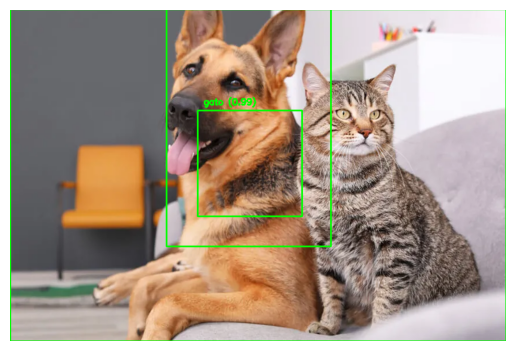

In [36]:
import torch.nn.functional as F

import matplotlib.pyplot as plt

image = cv2.imread("/content/0001.jpg")


rois=generate_rois(image,max_regiones=2000,fast_mode=False)

batch_indices = torch.zeros((rois.size(0), 1), dtype=torch.float32)

# Concatenar el índice del lote al inicio de cada ROI
rois_with_index = torch.cat((batch_indices, rois), dim=1).to(device)

# SVM modelo

transform = transforms.Compose([
    transforms.ToTensor()  # Convierte a tensor

])

imagen_tensor=transform(image).to(device)

model.eval()

with torch.no_grad():

  class_logits, bbox_deltas = model(imagen_tensor.unsqueeze(0),rois_with_index)

  probs = F.softmax(class_logits, dim=1)

  predicted_labels=torch.argmax(probs,dim=1)


selected_indices=[indice for indice in range(len(predicted_labels)) if(predicted_labels[indice] !=0)]

boxes_filtered = rois[selected_indices].to(device)
labels_filtered = predicted_labels[selected_indices].to(device)
scores_filtered = probs[selected_indices].to(device)
deltas_filtered = bbox_deltas[selected_indices].to(device)

# Aplicamos la transformación inversa
#pred_bbox_reales = reverse_translation(boxes_filtered , deltas_filtered)
pred_bbox_reales = boxes_filtered
pred_bbox_reales=pred_bbox_reales.to(device)

pred_bbox_reales=pred_bbox_reales


boxes_selected, scores_selected=non_maximum_suppression(pred_bbox_reales, scores_filtered, iou_threshold=0.3, prob_threshold=0.8)


boxes_selected_np = boxes_selected.detach().cpu().numpy()
scores_selected_np = scores_selected.detach().cpu().numpy()


print(probs.shape)

clases=['gato','perro']
for pred_bbox,score in zip(boxes_selected,scores_selected):
  cv2.rectangle(image, (int(pred_bbox[0]), int(pred_bbox[1])), (int(pred_bbox[2]), int(pred_bbox[3])), (0, 255, 0), 2)
  cv2.putText(image, f'{clases[torch.argmax(score)-1]} ({torch.max(score):.2f})', (int(pred_bbox[0])+10,int(pred_bbox[1])-10), cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 255, 0), 2)



plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Desactivar los ejes para mostrar solo la imagen
plt.show()








In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
